# Multiple Linear Regression, Part 2: 

## Model Validation

Today we'll focus on how to validate our models.

### Set Up Our Data Again

In [2]:
# Basic imports

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt
import seaborn as sns

Credit data from https://www.kaggle.com/avikpaul4u/credit-card-balance

Target: `Balance`

In [3]:
# Data
df = pd.read_csv('data/Credit.csv', 
                 usecols=['Income', 'Limit', 'Rating', 'Age', 'Balance'])

In [4]:
df.head()

,Income,Limit,Rating,Age,Balance
0,14.891,3606,283,34,333
1,106.025,6645,483,82,903
2,104.593,7075,514,71,580
3,148.924,9504,681,36,964
4,55.882,4897,357,68,331


In [5]:
df.describe()

,Income,Limit,Rating,Age,Balance
count,400.000000,400.000000,400.000000,400.000000,400.000000
mean,45.218885,4735.600000,354.940000,55.667500,520.015000
std,35.244273,2308.198848,154.724143,17.249807,459.758877
min,10.354000,855.000000,93.000000,23.000000,0.000000
25%,21.007250,3088.000000,247.250000,41.750000,68.750000
50%,33.115500,4622.500000,344.000000,56.000000,459.500000
75%,57.470750,5872.750000,437.250000,70.000000,863.000000
max,186.634000,13913.000000,982.000000,98.000000,1999.000000


In [1]:
sns.pairplot(df)

NameError: name 'sns' is not defined

## Modeling Practice

Last time, we left off after identifying some issues in our initial multiple linear regression model. Let's build that model back - now, with sklearn! - and then discuss one change we can implement and see if it improves our model.

In [6]:
# Imports
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [8]:
# Define X and y

used_cols = [c for c in df.columns if c not in ['Balance']]

X = df[used_cols]
y = df['Balance']

In [9]:
# Let's be sure to scale our X variables

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

In [11]:
# Fit our model!
lr = LinearRegression()

lr.fit(X_scaled, y)

LinearRegression()

In [15]:
# Grab our predictions and evaluate
y_preds = lr.predict(X_scaled)

print(f"R2 Score: {r2_score(y, y_preds):.4f}")
print(f"MAE: {mean_absolute_error(y, y_preds):.4f}")
print(f"RMSE: {mean_squared_error(y, y_preds, squared=False):.4f}")

R2 Score: 0.8772
MAE: 120.3084
RMSE: 160.8886


In [16]:
# MAE is in the same units as our Y 
# MAE is the average of the difference 
# between the predicted and measured values 

# RMSE = differences are over-emphasized

In [19]:
lr.coef_
# A way to get the coefficients 
# Aligns with each of the four used columns 

array([-267.96762972,  188.64828933,  422.08825003,  -14.74939325])

In [21]:
lr.intercept_
# Y-intercept is stored separately

520.0150000000001

(array([ 27., 111.,  95.,  76.,  28.,  23.,  11.,  11.,  12.,   6.]),
 array([-249.61848088, -170.00497143,  -90.39146197,  -10.77795252,
          68.83555694,  148.44906639,  228.06257584,  307.6760853 ,
         387.28959475,  466.90310421,  546.51661366]),
 <BarContainer object of 10 artists>)

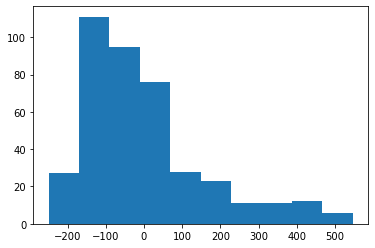

In [17]:
# Visualize our residuals
residuals = y - y_preds 

plt.hist(residuals)

#### What issues are there with this model?

- Residuals aren't normaly distributed; one one side we're off by more than the other
- Multicollinearity between our x variables 


#### Now, make a change!

- just use a few x variables


In [22]:
used_cols = ['Rating', 'Income']

X = df[used_cols]
y = df['Balance']

In [23]:
# Scale them again so that the two regressions can be compared 
scaler2 = StandardScaler()
X_scaled2 = scaler2.fit_transform(X)

In [24]:
lr2 = LinearRegression()

lr2.fit(X_scaled2, y)

LinearRegression()

In [26]:
y_preds2 = lr2.predict(X_scaled2)

print(f"R2 Score: {r2_score(y, y_preds2):.4f}")
print(f"MAE: {mean_absolute_error(y, y_preds2):.4f}")
print(f"RMSE: {mean_squared_error(y, y_preds2, squared=False):.4f}")

R2 Score: 0.8751
MAE: 120.7972
RMSE: 162.2694


In [27]:
lr.coef_

array([-267.96762972,  188.64828933,  422.08825003,  -14.74939325])

In [28]:
lr2.intercept_

520.015

## Model Validation - AKA How to Build Generalizable Models

![validation gif from giphy](https://media.giphy.com/media/242wLqQerWkxd6GgHB/giphy.gif)

Our premise: Let's say you have a dataframe, with some number of rows of data, and that's all you have available to you. The hope is that you can train a model on this data that can then be used to make predictions about new data that comes in. You want your model to _generalize_ well and work on this incoming data - not too complex from learning all the details/noise from the data, but also not so simple that the model is useless. How do we do that?

First, let's go into detail about this trade-off between simplicity and complexity:

### The Bias-Variance Trade Off

<img alt="original image from https://rmartinshort.jimdofree.com/2019/02/17/overfitting-bias-variance-and-leaning-curves/" src="images/underfit-goodfit-overfit.png" width=750, height=350>  

Remember - by modeling, we're assuming that there is some relationship between our X variables (the features in our dataset) and our y variable (the target). Thus, there is some underlying '_true_' function that captures the relationship between X and y, which we are trying to find by modeling. Of course, the actual relationship may be quite complex and not wholly represented in our data - our approximation, aka the model we create, is likely only a simplified estimator of whatever our '_true_' function actually would look like.

**Bias**: Error introduced by approximating a real-life problem (which may be extremely complicated) by a much simpler model (because the model is too simple to capture the underlying pattern)

**Variance**: Amount by which our model would change if we estimated it using a different training dataset (because the model is over-learning from the training data)

**Representation:**

<img alt="from https://hsto.org/files/281/108/1e9/2811081e9eda44d08f350be5a9deb564.png" src="images/bias-variance.png/" width=350, height=350>

## How To Minimize Bias and Variance

Good news! There are tried and true methods to reducing both bias and variance in our modeling process. Testing different models, trying models on different slices of data, transforming or engineering features - all of these things have a role to play in creating better, more robust models.

In particular, we've learned so far that we can evaluate the performance of our models, using a scoring metric, which will help us catch if a model is underfit - if it's performing quite poorly, it probably isn't capturing the relationship in our data! 

But what about overfitting?

<img alt="I Love Lucy shrug gif from Giphy" src="https://media.giphy.com/media/JRhS6WoswF8FxE0g2R/giphy.gif" width=350, height=350>

### Train-Test Split

The idea: don't train your model on ALL of your data, but keep some of it in reserve to test on, in order to simulate how it will work on new/incoming data.

#### Example:

<img alt="original image from https://www.dataquest.io/wp-content/uploads/kaggle_train_test_split.svg plus some added commentary" src="images/traintestsplit_80-20.png" width=850, height=150>  

Note - here, it looks like we're just taking the tail end of the dataset and setting it aside. In practice (most of the time), the split will randomly choose which rows are in the train vs. test sets.

How does this fight against overfitting? By witholding data from the training process, we are testing whether the model actually _generalizes_ well. If it does poorly on the test set, it's a good sign that our model learned too much noise from the train set and is overfit! 

![arrested development gif, found by Andy](https://heavy.com/wp-content/uploads/2013/05/tumblr_mjm9fqhrle1rvnnvyo6_250.gif)

#### Practice:

Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
print(X.shape)
X.head()

(400, 2)


,Rating,Income
0,283,14.891
1,483,106.025
2,514,104.593
3,681,148.924
4,357,55.882


In [31]:
print(y.shape)
y.head()

(400,)


0    333
1    903
2    580
3    964
4    331
Name: Balance, dtype: int64

In [33]:
# Train test split here!
# Set test_size = .33
# Set random_state = 42

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.33, random_state=42)

What did that do?

In [34]:
X_train.shape

(268, 2)

In [35]:
X_test.shape

(132, 2)

In [36]:
len(X_train + X_test) == len(X)

True

In [37]:
X_train.head()

,Rating,Income
258,215,41.400
177,292,22.379
119,137,23.012
194,181,30.406
229,547,69.943


Now let's put our train/test split into practice:

In [39]:
# Instantiate a new scaler to scale our data
# Let's use Standard Scaler here
scaler = StandardScaler()

In [40]:
# Fit our scaler - ON THE TRAINING DATA!!
# Then transform both train and test 
X_train_scaled = scaler.fit_transform(X_train)

# Same as:
# sclaer.fit(X_train)
# X_train_scaled = scaler.transform(X_train)

X_test_scaled = scaler.transform(X_test)

Quick aside: why is it so important to fit the scaler on the train set instead of the full set of X variables? Let's discuss what exactly these scalers are doing under the hood!

- 


**Rule of thumb:** if something is impacted by other rows in the dataset, it should _**only**_ learn from the training set!

In [41]:
# Instantiate an sklearn linear model
model = LinearRegression()

In [42]:
# Fit your model - ON THE TRAINING DATA!!
model.fit(X_train_scaled, y_train)

LinearRegression()

In [45]:
# Grab predictions for train and test set
y_pred_train  = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

In [46]:
# How'd we do?

print(f"Train R2 Score: {r2_score(y_train, y_pred_train)}")
print(f"Test R2 Score: {r2_score(y_test, y_pred_test)}")

Train R2 Score: 0.8810118091252546
Test R2 Score: 0.857746253201795


Evaluate!

- This is an indication of overfitting! We do better on our train data than ur test data



In [47]:
# Single variable example

X_single = df['Rating']
y = df['Balance']

In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    X_single, y, test_size=0.33, random_state=42)

In [49]:
scaler = StandardScaler()
X_s_train = scaler.fit_transform(X_train.values.reshape(-1, 1))
X_s_test = scaler.transform(X_test.values.reshape(-1, 1))

lr = LinearRegression()
lr.fit(X_s_train, y_train)
lr.score(X_s_test, y_test)

0.6656804809053132

### But Wait... There's More!

Let's change something and see what happens:

In [50]:
for n in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.33, 
                                                        random_state=n) # <--
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    lr = LinearRegression()
    lr.fit(X_train_scaled, y_train)
    
    y_pred_train = lr.predict(X_train_scaled)
    y_pred_test = lr.predict(X_test_scaled)
    
    print(f"Random Seed: {n}")
    print(f"Train R2 Score: {r2_score(y_train, y_pred_train)}")
    print(f"Test R2 Score: {r2_score(y_test, y_pred_test)}")
    print("-----")

Random Seed: 0
Train R2 Score: 0.8794274393370852
Test R2 Score: 0.8638964852587732
-----
Random Seed: 1
Train R2 Score: 0.8723139011791685
Test R2 Score: 0.8791035414499949
-----
Random Seed: 2
Train R2 Score: 0.8699112312293716
Test R2 Score: 0.8832396098019993
-----
Random Seed: 3
Train R2 Score: 0.8950039553815334
Test R2 Score: 0.8353584960458899
-----
Random Seed: 4
Train R2 Score: 0.8718383926546732
Test R2 Score: 0.8806890704120296
-----
Random Seed: 5
Train R2 Score: 0.8878718023897032
Test R2 Score: 0.8456963219083157
-----
Random Seed: 6
Train R2 Score: 0.8598046057830887
Test R2 Score: 0.9027024871969868
-----
Random Seed: 7
Train R2 Score: 0.8840698721013535
Test R2 Score: 0.8547020851246395
-----
Random Seed: 8
Train R2 Score: 0.8714547866856557
Test R2 Score: 0.8789529885089163
-----
Random Seed: 9
Train R2 Score: 0.873452698312308
Test R2 Score: 0.8777877303508429
-----


If you're doing much better on the test score than the train score in some cases, it might be a sign of underfitting. Vice versa = a sign of overfitting

What's happening here? All we're doing is changing our `random_seed` - why is that having such an impact on our model's scores? Some models appear overfit, some don't - and for some, the test score is **better** than our train score!

### K-Fold Cross-Validation

Sometimes, random chance means your training data isn't representative, or includes wacky data like all of our outliers. So, why do just one train-test split when you can do `k` number of them!

![cross validation image from kaggle: https://www.kaggle.com/alexisbcook/cross-validation](images/cross-validation.png)

The good news is, we'll never actually have to do this by hand - `sklearn` will handle it for us!

Documentation: https://scikit-learn.org/stable/modules/cross_validation.html

K- fold cross variation does k number of train-test splits

In [51]:
# Scale our data

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
# Note - in practice, better to scale within the cross validate...
# But we're saving how to do that with pipelines til later

In [52]:
# Instantiate a fresh linear regression model
lr = LinearRegression()

In [58]:
# Let's use cross_val_score
# Set cv = 5
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lr, X_scaled, y, cv=5)

In [59]:
# Look at the test scores across our folds
scores
# Scores are by default r-squared

array([0.85775875, 0.85167677, 0.88866637, 0.87336143, 0.88521897])

In [60]:
# Print it nicely
print(f"Scores: {scores.mean():.3f} +/- {scores.std():.3f}")

Scores: 0.871 +/- 0.015


Why show the standard deviation of scores here? I want some measure of the variance among my scores, so I can tell how different my scores were based on different breakdowns of the training data.

If I made a change to my model and the average of my cross-validated scores stayed about the same, but the variance among those scores decreased, that's a better, more generalizable model than before!

### Additional Resources:

- [Great bias/variance infographic](https://elitedatascience.com/bias-variance-tradeoff) from Elite Data Science
- Taking a more statistical approach? [Probabilistic Model Selection with AIC, BIC, and MDL](https://machinelearningmastery.com/probabilistic-model-selection-measures/) 